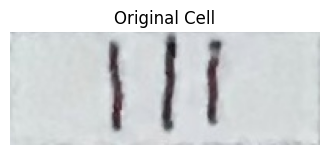

Classification:  Vertical lines
Count:  3


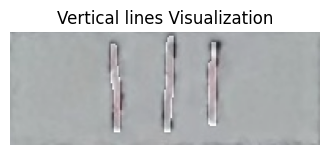

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from utils import *

def hasQuestionMark(cellImage):
    minCircleRadius = 3
    maxCircleRadius = 10
    minLineLength = 10
    grayScale = cv.cvtColor(cellImage, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(grayScale, 128, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)

    # Detect small circles (the dot)
    circles = cv.HoughCircles(binary, cv.HOUGH_GRADIENT, dp = 1, minDist = 5, param1 = 50, param2 = 10, minRadius = minCircleRadius, maxRadius = maxCircleRadius)
    if circles is None:
        return False, None

    # Detect vertical line by applying opening
    verticalLinesSE = cv.getStructuringElement(cv.MORPH_RECT, (1, minLineLength))
    verticalLines = cv.morphologyEx(binary, cv.MORPH_OPEN, verticalLinesSE, iterations = 1)
    contours, _ = cv.findContours(verticalLines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return False, None

    return True, verticalLines


def hasSquare(cellImage):
    minArea = 20
    aspectRatioTolerance = 0.4
    grayScale = cv.cvtColor(cellImage, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(grayScale, 128, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    SE = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    binary = cv.morphologyEx(binary, cv.MORPH_OPEN, SE, iterations = 1)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        perimeter = cv.arcLength(contour, True)
        approximatePolygon = cv.approxPolyDP(contour, 0.02 * perimeter, True)
        area = cv.contourArea(contour)
        if len(approximatePolygon) == 4 and area > minArea:
            x, y, width, height = cv.boundingRect(approximatePolygon)
            aspectRatio = width / float(height)
            if (1 - aspectRatioTolerance) <= aspectRatio <= (1 + aspectRatioTolerance):
                return True, contour
    return False, None


# Detects lines that match the right arm of a tick (/)
def hasTick(cellImage):
    minLineLength = 60
    grayScale = cv.cvtColor(cellImage, cv.COLOR_BGR2GRAY)
    thresh = cv.adaptiveThreshold(grayScale, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)

    lines = cv.HoughLinesP(thresh, 1, np.pi/180, threshold = 15, minLineLength = 20, maxLineGap = 5)
    
    if lines is None:
        return False, None

    detectedMask = np.zeros_like(grayScale)
    foundValidLine = False

    for line in lines:
        x1, y1, x2, y2 = line[0]

        if x1 > x2:
            x1, y1, x2, y2 = x2, y2, x1, y1

        dx = x2 - x1
        dy = y1 - y2 
        
        length = math.sqrt(dx**2 + dy**2)
        if length < minLineLength:
            continue

        angle = math.degrees(math.atan2(dy, dx))
        if 15 <= angle <= 62:
            cv.line(detectedMask, (x1, y1), (x2, y2), 255, 2)
            foundValidLine = True

    return foundValidLine, detectedMask


def detectHorizontalLines(cellImage):
    minLineLength = 20
    gray = cv.cvtColor(cellImage, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    horizontalSE = cv.getStructuringElement(cv.MORPH_RECT, (minLineLength, 1))
    horizontalLines = cv.morphologyEx(binary, cv.MORPH_OPEN, horizontalSE, iterations = 1)
    contours, _ = cv.findContours(horizontalLines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    count = len(contours)
    return count > 0, count, horizontalLines


def detectVerticalLines(cellImage):
    minLineLength = 20
    grayScale = cv.cvtColor(cellImage, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(grayScale, 128, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    verticalSE = cv.getStructuringElement(cv.MORPH_RECT, (1, minLineLength))
    verticalLines = cv.morphologyEx(binary, cv.MORPH_OPEN, verticalSE, iterations = 1)
    contours, _ = cv.findContours(verticalLines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    count = len(contours)
    return count > 0, count, verticalLines


def classifyCell(cellImage):
    questionMarkDetected, questionMarkMask = hasQuestionMark(cellImage)
    if questionMarkDetected:
        return "Question mark", 1, questionMarkMask

    squareDetected, squareMask = hasSquare(cellImage)
    if squareDetected:
        return "Square", 1, squareMask

    tickDetected, tickMask = hasTick(cellImage)
    if tickDetected:
        return "Tick", 1, tickMask

    vDetected, vCount, vMask = detectVerticalLines(cellImage)
    if vDetected:
        return "Vertical lines", vCount, vMask

    hDetected, hCount, hMask = detectHorizontalLines(cellImage)
    if hDetected:
        return "Horizontal lines", hCount, hMask

    return "No lines", 0, None


cellPath = "../data/cells/1/row_2_col_5.jpg"
cellImage = cv.imread(cellPath)
show_image(cellImage, "Original Cell")

classification, count, result = classifyCell(cellImage)
print("Classification: ", classification)
print("Count: ", count)

# Draw square, question mark, tick, or line mask
outputImage = cellImage.copy()
if classification in ["Square"] and result is not None:
    cv.drawContours(outputImage, [result], -1, (0, 0, 255), 2)
elif classification in ["Question mark", "Tick", "Vertical lines", "Horizontal lines"] and result is not None:
    maskColor = cv.cvtColor(result, cv.COLOR_GRAY2BGR)
    output_img = cv.addWeighted(outputImage, 0.8, maskColor, 0.5, 0)

show_image(output_img, f"{classification} Visualization")
